<a href="https://colab.research.google.com/github/omerfalach/Death-Classification-FAERS/blob/main/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
##Installations for google colab
!pip install category_encoders
!pip install --upgrade plotly
!pip install squarify

In [15]:
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import pytz
import pickle
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
import os
import warnings
import random
from sklearn.preprocessing import StandardScaler
import requests
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay
import project_plots as op
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from datetime import datetime as dt

# Loading Data

In [4]:
##connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
##Loading Data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset.csv")

In [ ]:
# # naive_drugs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all_drugs_naive_first_rolecod.csv")
# # drug_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/all_drugs_tf_idf_listed.csv")
# indi_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/indications_listed.csv")
# # drug_list = drug_list.dropna(subset = ['drugname_clean'])
# # indi_list = indi_list.dropna(subset = ['indi_pt'])
# # naive_drugs = naive_drugs.drop(columns = ['drugname','dechal','rechal','drug_seq'])
# # drug_list = drug_list.drop(columns = ['Unnamed: 0']).rename(columns= {'drugname_clean':'drugname_listed','role_cod':'role_cod_listed'})
# naive = pd.merge(demo_outc,naive_drugs,how='left',on = ['primaryid'	,'caseid'])
# data = pd.merge(naive,drug_list,how='left',on = ['primaryid'	,'caseid'])
# data = pd.merge(data,indi_list,how='left',on = ['primaryid'	,'caseid'])

In [ ]:
##External source
health_score = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Compliance with the International Health Regulations BY COUNTRY.csv")

In [ ]:
data.head(10)

,primaryid,caseid,outc_cod,sex,age,age_cod,age_grp,wt,wt_cod,occr_country,init_fda_dt,fda_dt,event_dt,filename,drugname,role_cod,dechal,rechal,drug_seq,drugname_listed,role_cod_listed,indi_pt,#drugs_to_indi
0,35032933,3503293,HO,F,39.0,YR,NaN,83.0,KG,US,20000720,20150129,20000118.0,DEMO15Q1,AVONEX,PS,NaN,D,1.0,"['AVONEX', 'AVONEX', 'ZOLOFT', 'LIPITOR', 'SYN...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C']","['Benign neoplasm of thyroid gland', 'Depressi...","[1, 3, 1, 2]"
1,36655882,3665588,HO,F,35.0,YR,NaN,NaN,NaN,DE,20010611,20150106,NaN,DEMO15Q1,LEPONEX CLOZARIL CLOZAPINE,PS,NaN,D,1.0,"['LEPONEX CLOZARIL CLOZAPINE', 'CARBAMAZEPINE...","['PS', 'SS', 'SS']",['Schizoaffective disorder'],[3]
2,38671183,3867118,HO,F,54.0,YR,NaN,70.0,KG,US,20021107,20150119,20021015.0,DEMO15Q1,AVONEX,PS,NaN,D,1.0,"['AVONEX', 'ACETAMINOPHEN']","['PS', 'C']","['Influenza like illness', 'Multiple sclerosis']","[1, 1]"
3,38775713,3877571,LT,M,NaN,NaN,NaN,NaN,NaN,GB,20021210,20150226,NaN,DEMO15Q1,CLOZARIL,PS,NaN,D,1.0,['CLOZARIL'],['PS'],['Schizophrenia'],[1]
4,40954634,4095463,DE,F,65.0,YR,NaN,NaN,NaN,JP,20040226,20150123,20040204.0,DEMO15Q1,GLIVEC,PS,NaN,U,1.0,"['GLIVEC', 'GLIVEC', 'CYLOCIDE', 'LASIX', 'FOY']","['PS', 'SS', 'SS', 'C', 'C']","['Acute kidney injury', 'Blast cell crisis', '...","[1, 1, 1, 1, 1]"
5,41149942,4114994,HO,F,17.0,YR,A,NaN,NaN,NaN,20040319,20150218,200011.0,DEMO15Q1,TACROLIMUS,PS,D,D,1.0,"['TACROLIMUS', 'AZATHIOPRINE', 'UNSPECIFIED IN...","['PS', 'C', 'C', 'C', 'C', 'C', 'C']",['Liver transplant'],[1]
6,41352566,4135256,HO,F,46.0,YR,NaN,NaN,NaN,US,20040426,20150227,200303.0,DEMO15Q1,AVONEX,PS,NaN,D,1.0,"['AVONEX', 'AVONEX', 'RITALIN', 'WELLBUTRIN', ...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C', 'C', 'C']","['Contraception', 'Hypothyroidism', 'Multiple ...","[1, 1, 5]"
7,41943882,4194388,HO,F,75.0,YR,NaN,60.8,KG,NaN,20040712,20150226,20040321.0,DEMO15Q1,PREVACID,PS,Y,D,1.0,"['PREVACID', 'SYNTHROID', 'FOSAMAX']","['PS', 'C', 'C']",['Gastrooesophageal reflux disease'],[1]
8,42207644,4220764,OT,F,18.0,YR,A,NaN,NaN,US,20040901,20150310,200404.0,DEMO15Q1,ENBREL,PS,NaN,D,1.0,['ENBREL'],['PS'],['Psoriasis'],[1]
9,57166203,5716620,HO,M,54.0,YR,NaN,NaN,NaN,US,20050107,20150225,20041130.0,DEMO15Q1,AVONEX,PS,NaN,D,1.0,"['AVONEX', 'AVONEX']","['PS', 'SS']",['Multiple sclerosis'],[3]


In [8]:
data.columns

Index(['primaryid', 'caseid', 'outc_cod', 'sex', 'age', 'age_cod', 'age_grp',
       'wt', 'wt_cod', 'occr_country', 'init_fda_dt', 'fda_dt', 'event_dt',
       'filename', 'drugname', 'role_cod', 'dechal', 'rechal', 'drug_seq',
       'drugname_listed', 'role_cod_listed', 'indi_pt', '#drugs_to_indi'],
      dtype='object')

In [17]:
# data = data.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset.csv")
data = data.drop(columns = ['init_fda_dt','fda_dt', 'event_dt','dechal', 'rechal', 'drug_seq'])

In [ ]:
# def check_if_float(row):
#     return isinstance(row['drugname_listed'], float)

# map = data.apply(check_if_float, axis=1)
# filtered_rows =  data[map].copy()
# filtered_rows

In [18]:
infor =op.info_new(data,ignore_features= ['primaryid','caseid','drugname_listed','role_cod_listed','indi_pt','#drugs_to_indi'])
infor

Object types:
Ctype   float64  object
Column        2       9
X is composed of 6046950 samples and 17 features.


,colName,Non-null values,Nunique,Dtype,Unique
0,outc_cod,6046950,7,object,"[HO, LT, DE, OT, CA, DS, RI]"
1,sex,5241248,6,object,"[F, M, nan, UNK, P, T, I]"
2,age,3846136,14284,float64,"[39.0, 35.0, 54.0, nan, 65.0, 17.0, 46.0, 75.0..."
3,age_cod,3846507,6,object,"[YR, nan, DY, MON, DEC, WK, HR]"
4,age_grp,1094883,6,object,"[nan, A, C, N, T, E, I]"
5,wt,1381732,10259,float64,"[83.0, nan, 70.0, 60.8, 56.7, 90.7, 72.0, 42.0..."
6,wt_cod,1381706,2,object,"[KG, nan, LBS]"
7,occr_country,5975250,235,object,"[US, DE, GB, JP, nan, IT, NO, FR, BE, ES, CA, ..."
8,filename,6046950,27,object,"[DEMO15Q1, DEMO20Q3, DEMO15Q2, DEMO15Q3, DEMO1..."
9,drugname,6046949,65376,object,"[AVONEX, LEPONEX CLOZARIL CLOZAPINE, CLOZARIL..."


In [ ]:
#normlaize age column to Years
def fixed_age(df,age,age_code):
    df.loc[(df[age]<=12) & df[age_code] == "DEC", age] = df[age]*10
    df.loc[df[age_code] == "MON", age] = df[age]/12
#     
    df.loc[df[age_code] == "MON", age] = df[age]/12
    df.loc[df[age_code]== "DY", age] = df[age]/365
    df.loc[df[age_code] == "WK", age] = df[age]/52
    df.loc[df[age_code] == "HR", age] = df[age]/8765.8127
    return df    

def fixed_weight(df,wt,wt_cod): 
        # unified weight unit
        df[wt] = df[wt].apply(pd.to_numeric, errors='coerce')
        df.loc[df[wt_cod] == "LBS", wt] = df[wt]  * 0.453592 # pounds
        df.loc[df[wt_cod]== "GMS", wt] = df[wt]* 0.001# grams
#         # weight discretization and label encode
#         wt_bins = [0, 5, 10, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300]
#         demo_df['wt'] = pd.cut(demo_df.wt, wt_bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
        return df
def fixed_label(df,label):
  df[label] = df[label].apply(lambda x: 1 if x=='DE' else 0)
  return df
def convert_str_to_list(x):
    try:
        z= x.strip('[]').replace("'", "").split(',')
        z1 = [f.strip() for f in z]
        return  z1
    except:
#         print(x)
        return x # replace with any suitable placeholder value
data['indi_pt']= data['indi_pt'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data['drugname_listed']= data['drugname_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data['role_cod_listed']= data['role_cod_listed'].apply(lambda x: convert_str_to_list(x) if type(x)!=float else x)
data_fixed = fixed_age(data,'age','age_cod')
data_fixed = fixed_weight(data_fixed,'wt', 'wt_cod')
data_fixed = fixed_label(data_fixed,'outc_cod')


In [ ]:
#count_indications_and_drugs_per_case
data_fixed['#drug_background'] = data_fixed['drugname_listed'].apply(lambda x: len(x) if type(x)!=float else x)
data_fixed['#indication_background'] = data_fixed['indi_pt'].apply(lambda x: len(x) if type(x)!=float else x)

# Outliers

In [ ]:
small_categorical = ['sex','age_grp']
large_categorical = ['occr_country']
continuous = ['age','wt','#drug_background','#indication_background'] 

### Outliers - Continuous Featuers

In [ ]:
X_continous = data_fixed[continuous]
X_continous.hist(figsize=(5,5),bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1021d366d0>,
      dtype=object)

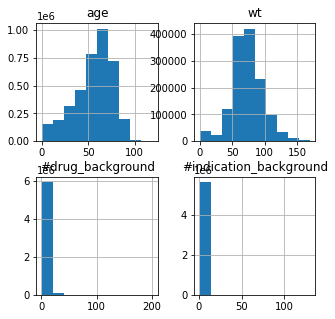

In [ ]:
data_fixed.loc[(data_fixed['age']>=120) | (naive_fixed['age']<=0) , 'age'] = np.nan
data_fixed.loc[(data_fixed['wt']>170), 'wt'] =  np.nan
X_continous_new = naive_fixed[continuous]
# X_aged_new = X_aged_wt_dropped[(X_aged_wt_dropped['age']<=121)&(X_aged_wt_dropped['age']>0) ]
X_continous_new.hist(figsize=(5,5))

### Outliers - Categorical Featuers

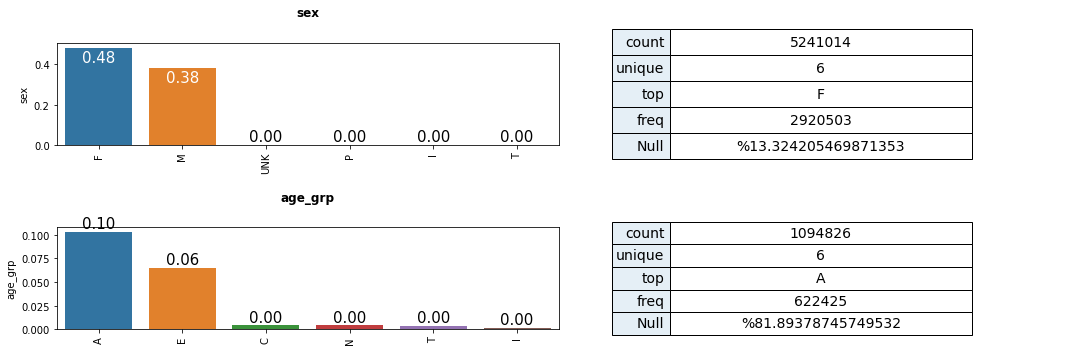

In [ ]:
##small categorical
op.plot_dist(data_fixed,small_categorical)

In [ ]:
sex_outliers = ['UNK','P','I','T']
data_fixed =  data_fixed[~data_fixed['sex'].isin(sex_outliers)]

In [ ]:
print(len(naive_fixed[naive_fixed['drugname_listed'].isna()]))
print(len(naive_fixed[naive_fixed['drugname_listed'].isna()]))


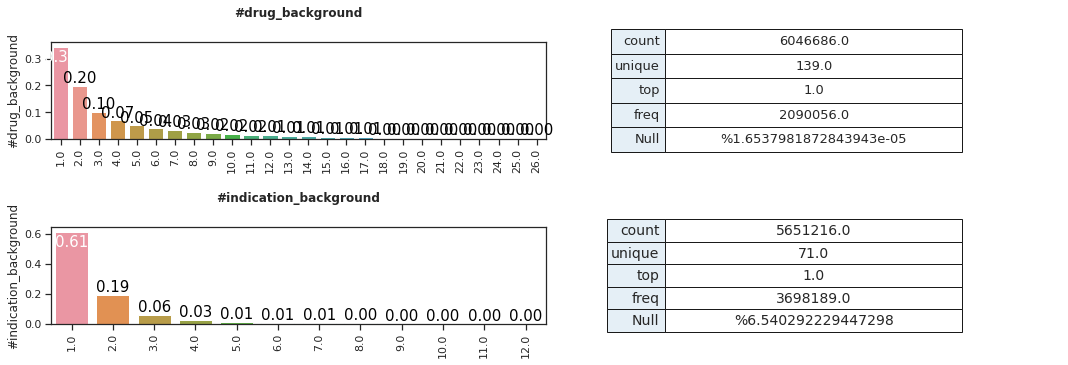

In [ ]:
op.plot_dist(data_fixed,['#drug_background','#indication_background'],limit = 0.001)

In [ ]:
# ##Large categorical
# op.plot_large_cate(naive_fixed,['occr_country'])

# Correlation

In [ ]:
def cramers_v(x, y): 
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
def point_biserial(x, y):

    pb = stats.pointbiserialr(x, y)
    return pb[0]

### Cont
Point biserial correlation
A point-biserial correlation is used to measure the strength and direction of the association that exists between one continuous variable and one dichotomous variable. It is a special case of the Pearson’s product-moment correlation, which is applied when you have two continuous variables, whereas in this case one of the variables is measured on a dichotomous scale [ref. ].


In [ ]:
data_fixed = data_fixed[['primaryid', 'caseid','sex','age','wt','occr_country', 'outc_cod']]
naive_fixed_new

,primaryid,caseid,sex,age,wt,occr_country,outc_cod
0,35032933,3503293,F,39.0,83.0,US,0
1,36655882,3665588,F,35.0,NaN,DE,0
2,38671183,3867118,F,54.0,70.0,US,0
3,38775713,3877571,M,NaN,NaN,GB,0
4,40954634,4095463,F,65.0,NaN,JP,1
...,...,...,...,...,...,...,...
6046682,1966917510,19669175,M,14.0,20.7,KR,0
6046683,1967419210,19674192,M,77.0,62.0,ES,0
6046684,1968277312,19682773,F,78.0,41.0,FR,1
6046685,1971800613,19718006,M,6.0,22.7,AR,0


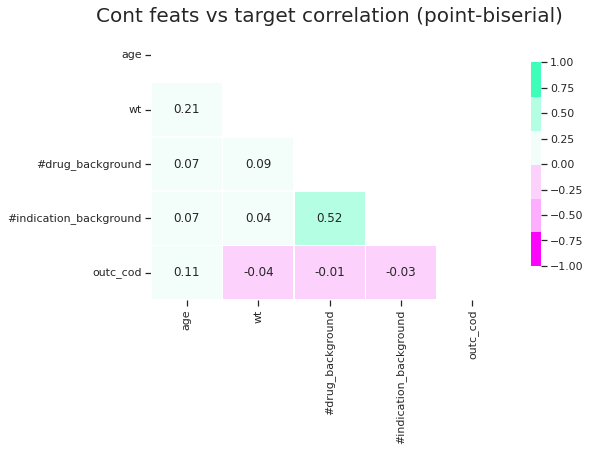

In [ ]:
# data = naive_fixed_new.copy()
data = data_fixed.copy()
mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']
feats_ = ['age','wt','#drug_background','#indication_background', 'outc_cod']
rows= []
for x in feats_:
    col = []
    for y in feats_ :
        if x==y:
            pbs = 1
        else:
            data1 = data[[x,y]]
            data1 = data1.dropna(subset=[x,y])
            pbs =point_biserial(data1[x], data1[y]) 
        col.append(round(pbs,2))  
    rows.append(col)  
    
pbs_results = np.array(rows)
DF = pd.DataFrame(pbs_results, columns = data[feats_].columns, index =data[feats_].columns)

mask = np.triu(np.ones_like(DF, dtype=bool))
corr = DF.mask(mask)

f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Cont feats vs target correlation (point-biserial)", fontsize=20, y= 1.05);

### Cat
Cramer's V correlation
In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic and was published by Harald Cramér in 1946. [ref. ]

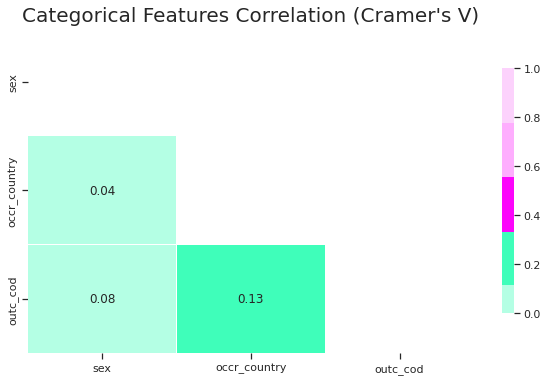

In [ ]:
# calculate the correlation coefficients using the above function
cat_feats = ['sex','occr_country','outc_cod']
data_ = data_fixed[cat_feats]
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y]) 
        col.append(round(cramers,2))
    rows.append(col)
    
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)

# color palette 
mypal_1= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA', '#FC05FB', '#FEAEFE', '#FCD2FC']
# plot the heat map
mask = np.triu(np.ones_like(df, dtype=bool))
corr = df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette(mypal_1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y= 1.05);

# Correlation to Label

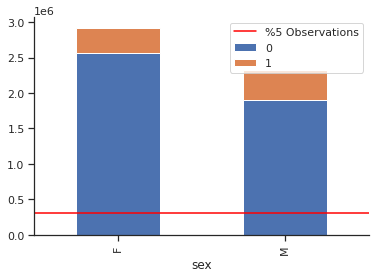

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


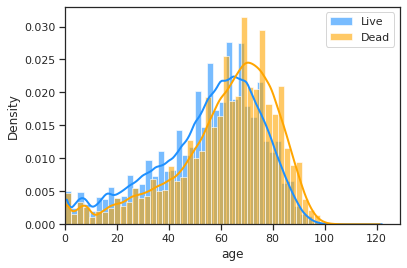

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


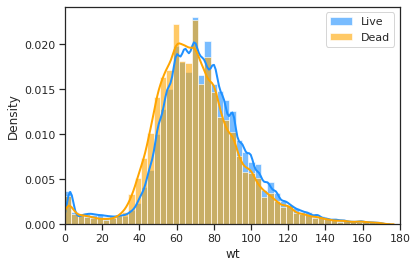

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


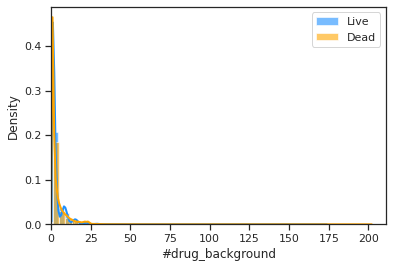

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


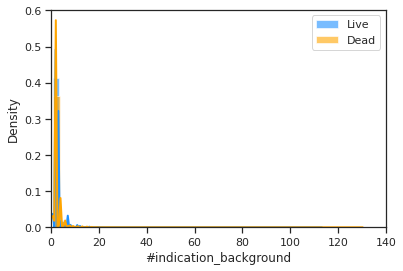

In [ ]:
# Small_CATEGORICAL_FEATURES = ['sex','#drug_background','#indication_background']
Small_CATEGORICAL_FEATURES = ['sex']

ignore_list = ['primaryid','caseid','outc_cod','occr_country','role_cod_listed','#drugs_to_indi','drugname','drugname_listed','indi_pt','wt_cod','role_cod','age_grp','age_cod','#drug_background','#indication_background']
for col in data_fixed.columns:
    if col in ignore_list:
        continue
    elif col in Small_CATEGORICAL_FEATURES:
        op.plot_label_corr_bar(data_fixed, col)
    else:
        op.plot_label_corr_hist(data_fixed, col)

In [ ]:
help(op.plot_label_corr_bar)

Help on function plot_label_corr_bar in module project_plots:

plot_label_corr_bar(X, col)



In [ ]:
op.treemap(naive_fixed,'drugname','outc_cod')


TypeError: ignored

In [ ]:
op.treemap(naive_fixed,'drugname','outc_cod')


In [ ]:
op.treemap(naive_fixed,'occr_country','outc_cod')

In [ ]:
naivedrug_clean = naive_fixed[['drugname_clean','outc_cod']]
df_plotdrug_clean = naivedrug_clean.groupby('drugname_clean').agg({'drugname_clean':'count',"outc_cod":"sum"})
del naivedrug_clean
df_plotdrug_clean= df_plotdrug_clean.rename(columns={'drugname_clean':'drugname_count'})
df_plotdrug_clean['precent'] = df_plotdrug_clean['outc_cod']/df_plotdrug_clean['drugname_count']
df_plotdrug_clean = df_plotdrug_clean.reset_index()
df_plotdrug1_clean = df_plotdrug_clean[df_plotdrug_clean['drugname_count']>=200]
fig = px.treemap(df_plotdrug1_clean, path=[px.Constant("drugname_clean"),'drugname_clean'], values='drugname_count',
                  color='precent', hover_data=['drugname_clean'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df_plotdrug1_clean['precent'], weights=df_plotdrug1_clean['drugname_count']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
# from IPython.display import display_html
# from itertools import chain,cycle
# df_plotdrug1_clean_sorted = df_plotdrug1_clean.sort_values(by='drugname_count', ascending=False)
# df_plotdrug1_sorted= df_plotdrug1.sort_values(by='drugname_count', ascending=False)
# def display_side_by_side(*args,titles=cycle([''])):
#     html_str=''
#     for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
#         html_str+='<th style="text-align:center"><td style="vertical-align:top">'
#         html_str+=f'<h2>{title}</h2>'
#         html_str+=df.to_html().replace('table','table style="display:inline"')
#         html_str+='</td></th>'
#     display_html(html_str,raw=True)
# display_side_by_side(df_plotdrug1_clean_sorted[100:150],df_plotdrug1_sorted[100:150], titles=['RAW','Cleaned']) 

In [ ]:
naivetest = naive_fixed[['occr_country','outc_cod']]
df_plot = naivetest.groupby('occr_country').agg({'occr_country':'count',"outc_cod":"sum"})
df_plot= df_plot.rename(columns={'occr_country':'country'})
df_plot['precent'] = df_plot['outc_cod']/df_plot['country']
df_plot = df_plot.reset_index()
fig = px.treemap(df_plot, path=[px.Constant("occr_country"),'occr_country'], values='country',
                  color='precent', hover_data=['occr_country'],
                  color_continuous_scale='RdYlGn',
                  color_continuous_midpoint=np.average(df_plot['precent'], weights=df_plot['country']))
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

# Missing Values

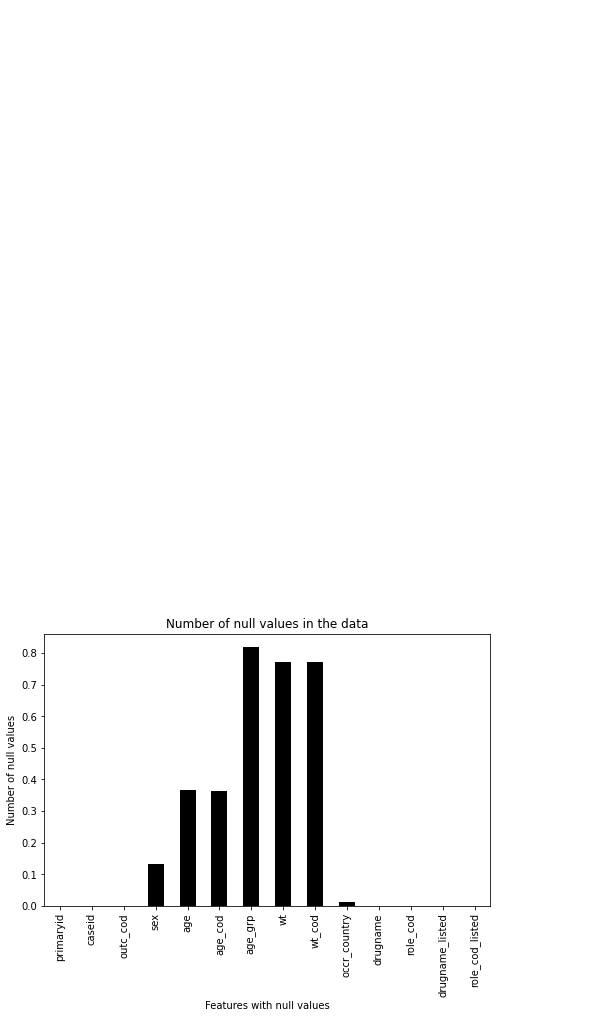

In [ ]:
X1 = naive_fixed
fig = plt.figure(figsize=(8, 5))
# null_columns=final_data1.columns[final_data1.isna().any()]
# ax = final_data1[null_columns].isnull().mean().plot(kind='bar',color='black')
ax = X1 .isna().mean().plot(kind='bar',color='black')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x(), p.get_height()+2))
plt.title('Number of null values in the data')
plt.xlabel('Features with null values')
plt.ylabel('Number of null values')
plt.show()

# Data Balance

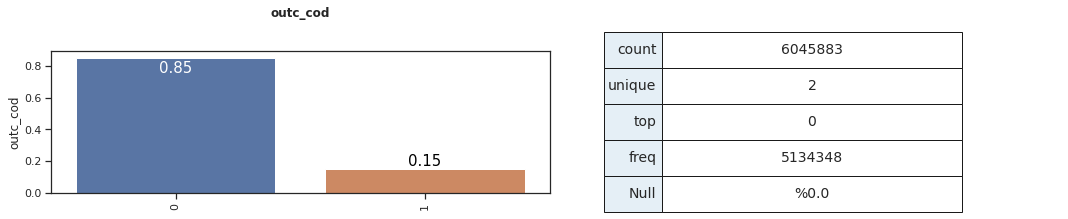

In [ ]:
op.plot_dist(naive_fixed,['outc_cod'])

In [ ]:
naive_fixed.head(10)

,primaryid,caseid,outc_cod,sex,age,age_cod,age_grp,wt,wt_cod,occr_country,drugname,role_cod,drugname_listed,role_cod_listed,indi_pt,#drugs_to_indi
0,35032933,3503293,0,F,39.0,YR,NaN,83.0,KG,US,AVONEX,PS,"['AVONEX', 'AVONEX', 'ZOLOFT', 'LIPITOR', 'SYN...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C']","['Benign neoplasm of thyroid gland', 'Depressi...","[1, 3, 1, 2]"
1,36655882,3665588,0,F,35.0,YR,NaN,NaN,NaN,DE,LEPONEX CLOZARIL CLOZAPINE,PS,"['LEPONEX CLOZARIL CLOZAPINE', 'CARBAMAZEPINE...","['PS', 'SS', 'SS']",['Schizoaffective disorder'],[3]
2,38671183,3867118,0,F,54.0,YR,NaN,70.0,KG,US,AVONEX,PS,"['AVONEX', 'ACETAMINOPHEN']","['PS', 'C']","['Influenza like illness', 'Multiple sclerosis']","[1, 1]"
3,38775713,3877571,0,M,NaN,NaN,NaN,NaN,NaN,GB,CLOZARIL,PS,['CLOZARIL'],['PS'],['Schizophrenia'],[1]
4,40954634,4095463,1,F,65.0,YR,NaN,NaN,NaN,JP,GLIVEC,PS,"['GLIVEC', 'GLIVEC', 'CYLOCIDE', 'LASIX', 'FOY']","['PS', 'SS', 'SS', 'C', 'C']","['Acute kidney injury', 'Blast cell crisis', '...","[1, 1, 1, 1, 1]"
5,41149942,4114994,0,F,17.0,YR,A,NaN,NaN,NaN,TACROLIMUS,PS,"['TACROLIMUS', 'AZATHIOPRINE', 'UNSPECIFIED IN...","['PS', 'C', 'C', 'C', 'C', 'C', 'C']",['Liver transplant'],[1]
6,41352566,4135256,0,F,46.0,YR,NaN,NaN,NaN,US,AVONEX,PS,"['AVONEX', 'AVONEX', 'RITALIN', 'WELLBUTRIN', ...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C', 'C', 'C']","['Contraception', 'Hypothyroidism', 'Multiple ...","[1, 1, 5]"
7,41943882,4194388,0,F,75.0,YR,NaN,60.8,KG,NaN,PREVACID,PS,"['PREVACID', 'SYNTHROID', 'FOSAMAX']","['PS', 'C', 'C']",['Gastrooesophageal reflux disease'],[1]
8,42207644,4220764,0,F,18.0,YR,A,NaN,NaN,US,ENBREL,PS,['ENBREL'],['PS'],['Psoriasis'],[1]
9,57166203,5716620,0,M,54.0,YR,NaN,NaN,NaN,US,AVONEX,PS,"['AVONEX', 'AVONEX']","['PS', 'SS']",['Multiple sclerosis'],[3]


# Split Train-Test

In [ ]:
# naive_fixed = naive_fixed[naive_fixed['occr_country'].notnull()]
# naive_fixed = naive_fixed[naive_fixed['outc_cod'].notnull()]
naive_fixed= naive_fixed.dropna(subset=['outc_cod', 'occr_country','drugname_listed','indi_pt'])
naivefstra = naive_fixed.drop(columns = ['primaryid','caseid','wt_cod','role_cod','age_grp','age_cod','wt','#drugs_to_indi'])
del naive_fixed
# naive_fixed.to_csv(r"C:\Tel Aviv University\High Tech\Year 3\Introduction to Search, Information Retrieval and Recommender Systems\Project\FDA\Navie solution files\for_naive_train_before_droppingcolumns.csv")
# naivefstra.to_csv(r"C:\Tel Aviv University\High Tech\Year 3\Introduction to Search, Information Retrieval and Recommender Systems\Project\FDA\Navie solution files\for_naive_train.csv")

In [ ]:
naivefstra.head(10)

,outc_cod,sex,age,occr_country,drugname,drugname_listed,role_cod_listed,indi_pt,#drug_background,#indication_background
0,0,F,39.0,US,AVONEX,"[AVONEX, AVONEX, ZOLOFT, LIPITOR, SYNTHROI...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C']","[Benign neoplasm of thyroid gland, Depression...",7.0,4.0
1,0,F,35.0,DE,LEPONEX CLOZARIL CLOZAPINE,"[LEPONEX CLOZARIL CLOZAPINE, CARBAMAZEPINE, ...","['PS', 'SS', 'SS']",[Schizoaffective disorder],3.0,1.0
2,0,F,54.0,US,AVONEX,"[AVONEX, ACETAMINOPHEN]","['PS', 'C']","[Influenza like illness, Multiple sclerosis]",2.0,2.0
3,0,M,NaN,GB,CLOZARIL,[CLOZARIL],['PS'],[Schizophrenia],1.0,1.0
4,1,F,65.0,JP,GLIVEC,"[GLIVEC, GLIVEC, CYLOCIDE, LASIX, FOY]","['PS', 'SS', 'SS', 'C', 'C']","[Acute kidney injury, Blast cell crisis, Bla...",5.0,5.0
6,0,F,46.0,US,AVONEX,"[AVONEX, AVONEX, RITALIN, WELLBUTRIN, REME...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C', 'C', 'C']","[Contraception, Hypothyroidism, Multiple scl...",9.0,3.0
8,0,F,18.0,US,ENBREL,[ENBREL],['PS'],[Psoriasis],1.0,1.0
9,0,M,54.0,US,AVONEX,"[AVONEX, AVONEX]","['PS', 'SS']",[Multiple sclerosis],2.0,1.0
10,0,M,15.0,US,ACCUTANE,"[ACCUTANE, ACCUTANE, DIFFERIN, CLEOCIN T, ...","['PS', 'SS', 'C', 'C', 'C', 'C', 'C', 'C', 'C']","[Acne, Staphylococcus test positive]",9.0,2.0
11,0,F,NaN,US,ZOFRAN,"[ZOFRAN, ZOFRAN, REGLAN, PHENERGAN]","['PS', 'I', 'I', 'SS']","[Nausea, Vomiting]",4.0,2.0


In [ ]:
naivefstra['outc_cod'] = naivefstra['outc_cod'].astype(int)

# data_train_noinf = naivefstra.rename(columns = {'outc_cod':'label'})
# data_train_noinf = data_train_noinf.round(2)
def get_stratified_split(x,y,test_size = 0.2):
    n_folds = int(round(1/test_size))
    skf = StratifiedKFold(n_splits = n_folds, random_state = 0, shuffle = True)
    for tr_ind, test_ind in skf.split(x,y):
        break
    return tr_ind,test_ind

tr_ind, test_ind = get_stratified_split(np.zeros(len(naivefstra)),naivefstra['outc_cod'],test_size =0.2)
features = list(naivefstra.columns)
features.remove('outc_cod')
train_features = naivefstra[features].iloc[tr_ind]
test_features = naivefstra[features].iloc[test_ind]
train_labels = naivefstra['outc_cod'].iloc[tr_ind]
test_labels = naivefstra['outc_cod'].iloc[test_ind]

In [ ]:
naivefstra.head(10)

NameError: ignored

In [ ]:
# #last_version_includes_indications
# train_features.to_csv('/content/drive/MyDrive/Colab Notebooks/train_features1.csv',index = False)
# test_features.to_csv('/content/drive/MyDrive/Colab Notebooks/test_features1.csv',index = False)
# train_labels.to_csv('/content/drive/MyDrive/Colab Notebooks/train_labels1.csv',index = False)
# test_labels.to_csv('/content/drive/MyDrive/Colab Notebooks/test_labels1.csv',index = False)

In [ ]:
train_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_features1.csv')
test_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_features1.csv')
train_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_labels1.csv')
test_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_labels1.csv')

In [ ]:
class catProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.z = None
        self.y = None
#         self.min_samples_leaf = None

    def fit(self, X, y=None,min_samples_leaf = None):
#         self.min_samples_leaf = min_samples_leaf
#         if self.min_samples_leaf == None:
#             self.min_samples_leaf = 1000
        self.y = y
        if type(X.iloc[:, 0].iloc[0])==list:
            X.iloc[:, 0] = X.iloc[:, 0].apply(lambda row: row[0] if type(row)==list else 'empty')
        self.cat_transformer = Pipeline(steps=[('target encoding', TargetEncoder(cols = X.columns))])
        return self.cat_transformer.fit(X,y)
    def transform(self, X, y=None):
        if type(X.iloc[:, 0].iloc[0])==list:
            X.iloc[:, 0] = X.iloc[:, 0].apply(lambda row: row[0] if type(row)==list else 'empty')
        z = self.cat_transformer.transform(X)
#         print(z)
        return self.cat_transformer.transform(X)
    
class ageImputer(BaseEstimator, TransformerMixin) :
    def __init__(self, column = 'age'):
        self.death_chances = None
        self.live_chances = None
        self.column = column
        self.X1 = None
        self.y = None
        
    def get_age_new(self,d_chances,l_chances,column,out = -100):
        try:
            out = int(out)
            if out == 1:
                ages_unichoi = [random.uniform(i.left,i.right) for i in list(d_chances['age_groups'])]
                death_ages = random.choices(ages_unichoi, weights = list(d_chances[column]), k = 1)
                return round(death_ages[0], 1)
            elif out==0:
                ages_unichoi = [random.uniform(i.left,i.right) for i in list(l_chances['age_groups'])]
                live_ages = random.choices(ages_unichoi, weights = list(l_chances[column]), k = 1)
                return round(live_ages[0], 1)
            else:
                trans = random.choices(random.uniform(i.left,i.right), weights = list(d_chances[column]), k = 1)
                return  round(trans[0], 1)
        except:
            return -1

    def fit(self, X, y=None):
        self.y = y
        self.X1 = X.merge(self.y, right_index=True, left_index=True)
        X_fixed_age_not_null = self.X1[self.X1[self.column].notnull()]
        death = X_fixed_age_not_null[X_fixed_age_not_null['outc_cod']==1]
        live = X_fixed_age_not_null[X_fixed_age_not_null['outc_cod']==0]
        self.death_chances = death[self.column].value_counts(bins= 2 ,normalize = True).to_frame()
        self.death_chances = self.death_chances.reset_index().rename(columns = {'index':'age_groups'})
        self.live_chances = live[self.column].value_counts(bins= 2 ,normalize = True).to_frame()
        self.live_chances =self.live_chances.reset_index().rename(columns = {'index':'age_groups'})
#         print(self.live_chances)
        self.X1[self.column] = self.X1.apply(lambda row: self.get_age_new(self.death_chances,self.live_chances,self.column,row['outc_cod']) if np.isnan(row[self.column]) else row[self.column],axis=1)
#         print(self.X1,type(self.X1))
#         self.X1= self.X1[[self.column]]
#         print(self.X1,type(self.X1))
        X.iloc[:, 0] = self.X1[self.column]
#         self.X1 = self.X1.drop(columns = ['outc_cod'])
#         self.X1 = self.X1['']
        return  self                      
    def transform(self, X, y=None):
#         print(X)
        X1 = X.copy()
        X1.iloc[:, 0] = X1.iloc[:, 0].apply(lambda row: self.get_age_new(self.death_chances,self.live_chances,self.column) if np.isnan(row) else row)

        return X1

def cod_change(x):
    if x =='PS':
        return 0
    elif x == 'SS':
        return 1
    else:
        return random.choice([0,1])
def cod_transform_to_pipe(data):
    z = data.apply(lambda x: [cod_change(t) for t in x])
    return z
def sex_change(x):
    if x =='M':
        return 0
    elif x == 'F':
        return 1
    else:
        return random.choice([0,1])
def sex_transform_to_pipe(data):
#     print(data)
    z = data.apply(lambda x: [sex_change(t) for t in x])
#     print(data)
    return z
# def removing_na(data):
#     z = data[]
#     return z
def dummy_fun(doc):
    return doc
def squeeze_tifidf(data):
    return data.squeeze()
def tifidftoarry(data):
#     print(data.shape)
#     print(type(data))
    f  = data.toarray()
#     print(type(f))
    print(f.shape)
#     f  = data.flatten()
    print(f)
    return  f
def print_data(data):
    print(data)
#     print(data.get_shape)
    return data
# def tran
def tranlis(data):
#     print(data)
#     data.iloc[:, 0] = [" ".join(x) for x in data.iloc[:, 0].values]
# df['Reviews']=[" ".join(review) for review in df['Reviews'].values]
#     data.iloc[:, 0] = [" ".join(x) for x in data.iloc[:, 0].values]
    # print(data[0:10].iloc[:, 0])
    d = list(data.iloc[:, 0])
#     print(d[0:15])
#     print('success')
#     print(type(data.iloc[:, 0][0]),data.iloc[:, 0][0])
    return d

In [ ]:
drug_feature = ['drugname_listed']
age_feature = ['age']
sex_feature = ['sex']
cat_features = ['occr_country']
indi_feature = ['indi_pt']
catall_features = ['drugname','occr_country']
# drug_weighted_feature =['drugname_list_new']
all_features = ['age','sex','drugname','occr_country']
# tr_sequences1['drugname'] = [" ".join(review) for review in tr_sequences1['drugname'].values]
sex_transformer = Pipeline(steps=[('se',FunctionTransformer(sex_transform_to_pipe))])
print_transformer = Pipeline(steps=[('pr',FunctionTransformer(print_data))])
target_encoding_transformer = Pipeline(steps = [('target',TargetEncoder())])
tfidf_transformer=  Pipeline(steps=[
    ('extract_list',FunctionTransformer(tranlis,validate=False)),
    ('tf',TfidfVectorizer(analyzer = 'word',tokenizer=lambda x: x,
                        preprocessor=lambda x: x,lowercase = False))])
      # ('pr',FunctionTransformer(print_data,validate=False))])
#     lowercase = False
#     ('p',FunctionTransformer(print_data))
#      ('fix', FunctionTransformer(tifidftoarry,validate = False))])

ageImputer_transformer = Pipeline(steps = 
    [("age", ageImputer()),
        ('scale', StandardScaler())])
cat_transformer = Pipeline(steps=[('target encoding', catProcessor())])
drug_tf_idf_preprocessor =ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age2',ageImputer_transformer,age_feature),
    ('drug',tfidf_transformer,drug_feature),
    ('cate',cat_transformer,cat_features)
    # ('pprint',print_transformer,all_features)
])
indi_tf_idf_preprocessor =ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age2',ageImputer_transformer,age_feature),
    ('drug',tfidf_transformer,indi_feature),
    ('cate',cat_transformer,cat_features)
    # ('pprint',print_transformer,all_features)
])

naive_preprocessor = ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age',ageImputer_transformer,age_feature),
    ('cate',cat_transformer,catall_features)])
naive_preprocessor_new = ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age',ageImputer_transformer,age_feature),
    ('categorical',target_encoding_transformer,catall_features)])

In [ ]:
class modeling_omer():
    def __init__(self):
        # Initialze the general parameters
        self.score_to_optimize = 'AUC'
        self.verbose = 10
        self.n_experiments = int(1e1)
        self.n_jobs=-2 
        self.num_val_folds =  2
        self.splitter = StratifiedKFold(self.num_val_folds)
#         Initiaze scorers
        self.auc_scorer = None
        self.precision_scorer = None
        self.recall_scorer = None
        self.precision_recall_scorer = None
        self.scorers = dict
        self.hyper_opt = None 
    ##get roc_auc_score
    def get_roc_auc(self,gt, pred):
        return roc_auc_score(gt, pred, average='weighted')

    def get_precision(self,gt, pred):
        return precision_score(gt, pred, average='weighted')
    def get_recall(self,gt, pred):
        return recall_score(gt, pred, average='weighted')

    def get_precision_recall_fscore_support(self,gt, pred):
        precision,recall,f2_score,support = precision_recall_fscore_support(gt, pred,beta = 2,average='weighted')
        return f2_score
    #set_scorers
    def set_scorers(self):
        self.auc_scorer = make_scorer(self.get_roc_auc, needs_proba=True)
        self.precision_scorer = make_scorer(self.get_precision)
        self.recall_scorer = make_scorer(self.get_recall)
        self.precision_recall_scorer = make_scorer(self.get_precision_recall_fscore_support)
        self.scorers = {'AUC':  self.auc_scorer, 
           'Precision': self.precision_scorer, 'Recall': self.recall_scorer,
           'Accuracy': 'accuracy'}
    # #Plot Roc Curve
    # def plot_roc(self,false_positive_rate2, true_positive_rate2,auc1):
    #     plt.subplots(1, figsize=(10,10))
    #     plt.title('Receiver Operating Characteristic - LogisticRegression')
    #     plt.plot(false_positive_rate2, true_positive_rate2)
    #     plt.plot([0, 1], ls="--")
    #     plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    #     plt.plot(false_positive_rate2,true_positive_rate2,label="auc="+str(auc1))
    #     plt.ylabel('True Positive Rate')
    #     plt.xlabel('False Positive Rate')
    #     plt.show()
    # #Plot PR curve
    # def pre_rec(self,recall, precision):
    #     fig, ax = plt.subplots()
    #     ax.plot(recall, precision, color='purple')

    #     #add axis labels to plot
    #     ax.set_title('Precision-Recall Curve')
    #     ax.set_ylabel('Precision')
    #     ax.set_xlabel('Recall')
    #     #display plot
    #     plt.show()
    def cm_plot(self,modelt,test_features,test_labels,thresholds = [0.5,0.75,0.85,0.9,0.95]):
      threshold_list= thresholds
      fig, axn = plt.subplots(1,len(threshold_list), sharex=True, sharey=True,figsize=(20,4))
      for i, ax in enumerate(axn.flat):
          th = float(threshold_list[i])
          y_pred = (modelt.predict_proba(test_features)[:, 1] >th).astype('float')
          cm2 = confusion_matrix(test_labels, y_pred,normalize='pred')
          disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
                        display_labels=modelt.classes_)
          disp.plot(ax=ax,cmap="Blues")
          disp.ax_.set_title(title)
          ax.set_title("Normalized, treshold = " + str(threshold_list[i]),fontsize=8)
      plt.subplots_adjust(wspace=0.40, hspace=0.1)
    def optimize_predict(self,train_features, train_labels,test_features,test_labels,pipeline,param):
        print(type(train_labels[0:10]))
        self.set_scorers()
        self.hyper_opt = RandomizedSearchCV(pipeline, param,n_iter = self.n_experiments,
                           scoring = self.scorers, n_jobs =  self.n_jobs, cv=self.splitter,
                           refit=self.score_to_optimize,pre_dispatch =2,
                           return_train_score=False, verbose=self.verbose)
        tr_val_sequences, tr_val_labels = train_features, train_labels
        num_label_apperances = tr_val_labels.value_counts()
        min_label_apperances = min(num_label_apperances)
        if self.num_val_folds > min_label_apperances:
            self.hyper_opt.cv = StratifiedKFold(min_label_apperances)
        start_time = dt.now()
        print(f"Fitting (training) the models and performing hyper parameter search. "
              f"Time: {start_time}")
        self.hyper_opt.fit(tr_val_sequences, tr_val_labels)
        best_ind = self.hyper_opt.best_index_
        scores = {}
        for scorer in self.scorers:
            scores[scorer] = self.hyper_opt.cv_results_['mean_test_' + scorer][best_ind]
        scores_str = '\n'.join(f"{k}: {v:.3f}" for k, v in scores.items())
        print(f'---Algorithm performance---: \n{scores_str}\n-------------')

        ##Prediction
        y_predict = self.hyper_opt.predict(test_features)
        y_scores = self.hyper_opt.predict_proba(test_features)[:, 1]
        fpr, tpr, thresholds =roc_curve(test_labels, y_scores)
        precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
        auc = roc_auc_score(test_labels, y_scores)
        fig, axes = plt.subplots(1,2, figsize = (20,10))
        op.pre_rec(recall, precision,ax = axes[0])
        op.plot_roc(fpr, tpr,auc,ax = axes[1])
        op.cm_plot(hyper_opt,test_features,test_labels)

        # try:  
        #   self.cm_plot(hyper_opt,test_features,test_labels)
        # except:
        #   print("cant print cm")
        # print(hyper_opt.cv_results_)
        end_time = dt.now()
        duration = (end_time - start_time).total_seconds()
        print(f'Training took {duration} seconds')


In [ ]:
class train_omer(modeling_omer):
        def __init__(self,preprocessors = [naive_preprocessor]):
            modeling_omer.__init__(self)
            self.reg_coef_logrange = (0, 3, 5)
            self.min_dfs_logrange = (0, 2, 1)
            # Initialze featuers
            self.drug_feature = ['drugname']
            self.age_feature = ['age']
            self.sex_feature = ['sex']
            self.cat_features = ['occr_country']
            self.catall_features = ['drugname','occr_country']
            self.naive_preprocessor = preprocessors
            # Initialze the estimators
            self.clf1 = LogisticRegression()
            self.clf2 = RandomForestClassifier()
            self.clf3 = KNeighborsClassifier()
            self.classifiers = [self.clf1,self.clf2,self.clf3]
            # self.classifiers = [self.clf1]
            self.models = []
            # Initiaze dictionaries for hyperparameters
            self.param1 = {}
            self.param2 = {}
            self.param3 = {}
            self.params = {}
        def log_range(self,lower, upper, samples_per_decade, is_int=True):
            samples = 1 + (upper - lower) * samples_per_decade
            samples = int(round(samples))
            if is_int:
                return [int(round(i)) for i in np.logspace(lower, upper, samples)]
            else:
                return list(np.logspace(lower, upper, samples))
       
        def set_hyperparameters(self): #hyperparameters for each classifier
            ##fill logistic regression parameters
            self.param1['feature_extractor']= self.naive_preprocessor
            self.param1['feature_extractor__drug__tf__min_df']= [0.01,0.05,0.1]
            # self.param1['feature_extractor__categorical__target__smoothing']= [0.1,1,10]
            self.param1['classifier__solver']=['lbfgs']
            self.param1['classifier__multi_class']=['auto']
            self.param1['classifier__max_iter']=[int(1e6)]
            self.param1['classifier__class_weight']=['balanced']
            self.param1['classifier__C'] = self.log_range(*self.reg_coef_logrange, is_int=False)
#             self.param1['classifier__penalty'] = ['l1', 'l2']
            self.param1['classifier'] = [self.clf1]

             ##fill randomforest parameters
            self.param2['feature_extractor']=self.naive_preprocessor
            self.param2['classifier__n_estimators'] = [10]
            self.param2['classifier__max_depth'] = [5, 10, 20]
            self.param2['classifier__class_weight'] = ['balanced_subsample']
            self.param2['classifier'] = [self.clf2]

            ##fill knn parameters
            self.param3['feature_extractor']=[naive_preprocessor],
            self.param3['classifier__n_neighbors'] = [5,10,25,50]
            self.param3['classifier'] = [self.clf3]
            self.params = [self.param1,self.param2,self.param3]
            # self.params = [self.param1]
        def train_pipes(self,train_features, train_labels,test_features,test_labels):
                self.set_hyperparameters()
                print(type(train_labels[0:10]))
                for i in self.classifiers:
                    print(i)
                    p = Pipeline(steps = [('feature_extractor','passthrough'),('classifier',i)])
#                     print(p)
                    self.optimize_predict(train_features, train_labels,test_features,test_labels,p, self.params)
                    self.models.append(self.hyper_opt)
                return self.models

In [ ]:
# def cm_plot(modelt,test_features,test_labels,thresholds = [0.5,0.75,0.85,0.9,0.95]):
#       threshold_list= thresholds
#       fig, axn = plt.subplots(1,len(threshold_list), sharex=True, sharey=True,figsize=(20,4))
#       for i, ax in enumerate(axn.flat):
#           th = float(threshold_list[i])
#           y_pred = (modelt.predict_proba(test_features)[:, 1] >th).astype('float')
#           cm2 = confusion_matrix(test_labels, y_pred,normalize='pred')
#           disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
#                         display_labels=modelt.classes_)
#           disp.plot(ax=ax,cmap="Blues")
#           disp.ax_.set_title(title)
#           ax.set_title("Normalized, treshold = " + str(threshold_list[i]),fontsize=8)
#       plt.subplots_adjust(wspace=0.40, hspace=0.1)
# cm_plot(model,test_features,test_labels)

In [ ]:
# z = train_omer([naive_preprocessor,indi_tf_idf_preprocessor])
import drug_project_plots as op
z = train_omer([drug_tf_idf_preprocessor])
models = z.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])

<class 'pandas.core.series.Series'>
LogisticRegression()
<class 'pandas.core.series.Series'>
Fitting (training) the models and performing hyper parameter search. Time: 2022-01-24 00:29:18.090986
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START classifier=LogisticRegression(), classifier__C=39.810717055349734, classifier__class_weight=balanced, classifier__max_iter=1000000, classifier__multi_class=auto, classifier__solver=lbfgs, feature_extractor=ColumnTransformer(transformers=[('sex',
                                 Pipeline(steps=[('se',
                                                  FunctionTransformer(func=<function sex_transform_to_pipe at 0x7fcd67be27a0>))]),
                                 ['sex']),
                                ('age2',
                                 Pipeline(steps=[('age', ageImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
           

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 316, in _fit
    self._validate_steps()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 2

---Algorithm performance---: 
AUC: 0.612
Precision: 0.778
Recall: 0.703
Accuracy: 0.703
-------------
Training took 5942.01205 seconds
RandomForestClassifier()
<class 'pandas.core.series.Series'>
Fitting (training) the models and performing hyper parameter search. Time: 2022-01-24 02:08:20.150840
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START classifier=LogisticRegression(C=39.810717055349734, class_weight='balanced',
                   max_iter=1000000), classifier__C=1.0, classifier__class_weight=balanced, classifier__max_iter=1000000, classifier__multi_class=auto, classifier__solver=lbfgs, feature_extractor=ColumnTransformer(transformers=[('sex',
                                 Pipeline(steps=[('se',
                                                  FunctionTransformer(func=<function sex_transform_to_pipe at 0x7fcd67be27a0>))]),
                                 ['sex']),
                                ('age2',
                                 Pip

In [ ]:
import joblib
m= 0
for i in models:
  filename = '/content/drive/MyDrive/Colab Notebooks/drug_tf_idf_new_model_'+ str(m) + ".sav"
  joblib.dump(i, filename)
  m+=1 

NameError: ignored

{0.0, 1.0}


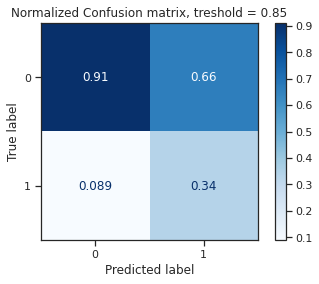

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# threshold_list = [0.5,0.75,0.85,0.9,0.95]
threshold_list = [0.85]
modelt = z.hyper_opt
for i in threshold_list:
  # train_features, train_labels,test_features,test_labels
  y_pred1 = modelt.predict(test_features)
  y_pred = (modelt.predict_proba(test_features)[:, 1] > i).astype('float')
  print(set(y_pred))
  # cm2 = confusion_matrix(test_labels, y_pred,normalize='pred')
  title = "Normalized Confusion matrix, treshold = " + str(i)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
          display_labels=modelt.classes_)
  disp = ConfusionMatrixDisplay(test_labels,y_pred1)
  disp.plot(cmap="Blues")
  disp.ax_.set_title(title)

  # print(title)
  # print(disp.confusion_matrix)

In [ ]:
import project_plots_new2 as op
op.cm_plot(z.hyper_opt,test_features,test_labels)

ModuleNotFoundError: ignored